In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from classes import (ColumnDropper, ConditionalRowRemover, CustomImputer,
                     CustomLabelEncoder, CustomPowerTransformer,
                     DuplicateRemover, NewColumnTransformer,
                     NormalizeTransformer, OutlierRemover_IQR)
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
file_path = r"C:\Users\kompu\Desktop\HotelCustomersDataset.csv"
raw_data = pd.read_csv(file_path, index_col="ID")
raw_data

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,
1,PRT,51.0,150,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,45,371.0,105.3,1,0,...,0,0,0,0,0,0,0,0,0,0
2,PRT,NaN,1095,0x21EDE41906B45079E75385B5AA33287CA09DE1AB86DE...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,61,280.0,53.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DEU,31.0,1095,0x31C5E4B74E23231295FDB724AD578C02C4A723F4BA2B...,0xC7CF344F5B03295037595B1337AC905CA188F1B5B3A5...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FRA,60.0,1095,0xFF534C83C0EF23D1CE516BC80A65D0197003D27937D4...,0xBD3823A9B4EC35D6CAF4B27AE423A677C0200DB61E82...,93,240.0,60.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,FRA,51.0,1095,0x9C1DEF02C9BE242842C1C1ABF2C5AA249A1EEB4763B4...,0xE175754CF77247B202DD0820F49407C762C14A603B3A...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83586,ITA,54.0,0,0x68010434A46BA6CEAFFACF00B7B7CD0E1825DC56E68F...,0x0A4038E9AE1E4E5A14832BEACEC6BCBE2219F275B65C...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
83587,IRL,47.0,0,0x6DE7954E6AF065D29EF5C57D0DC8120FBAE6753D2CCB...,0xC0654B6A53840DD95DAE429966EC16E2A11FB186CC7B...,109,327.1,277.5,0,0,...,0,0,0,0,1,0,0,0,0,0
83588,IRL,53.0,0,0x533C977BA6D1D8DFAD8D8D4C2250236D16EFD17B9F35...,0x3DCBEB254247836015CA95F0BBF42E6AF6A158380663...,0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
final_preprocessing_pipeline = make_pipeline(
    NewColumnTransformer(columns=["LodgingRevenue", "OtherRevenue"], operation="add", new_column_name="TotalRevenue"),
    NewColumnTransformer(columns=["PersonsNights", "RoomNights"], operation="divide", new_column_name="PersonsRoomNight"),
    ColumnDropper(columns_to_drop=["PersonsNights", "RoomNights", "LodgingRevenue", "OtherRevenue", 
                                   "DaysSinceFirstStay", "DaysSinceLastStay",
                                   "BookingsCanceled", "BookingsNoShowed", 
                                   "SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", 
                                   "SRBathtub", "SRShower", "SRCrib", "SRNearElevator", "SRAwayFromElevator", 
                                   "SRNoAlcoholInMiniBar", "NameHash", "DocIDHash", 
                                   "SRKingSizeBed", "SRTwinBed", "SRQuietRoom"]),   # New columns to drop
    DuplicateRemover(),
    ConditionalRowRemover(conditions={
    "LodgingRevenue": 0,    # Assuming total amount spent on lodging expenses by the customer cannot be 0
    "AverageLeadTime": -1   # Assuming, the average number of days elapsed between the customer's booking date and arrival date cannot be negative
                            # The only negative value appearing in this column is -1
    }),
    CustomImputer(strategy="mean", columns=["Age"]),
    OutlierRemover_IQR(),
    CustomLabelEncoder(columns=["Nationality", "DistributionChannel", "MarketSegment"]),
    NormalizeTransformer(norm='l2'),
    CustomPowerTransformer(columns=["Nationality", "Age", "DaysSinceCreation", "BookingsCheckedIn",
                                    "AverageLeadTime", "PersonsRoomNight", "TotalRevenue",
                                    "MarketSegment", "DistributionChannel"], standardize=True)
)

In [4]:
df_done = final_preprocessing_pipeline.fit_transform(raw_data)
df_done

,Nationality,Age,DaysSinceCreation,AverageLeadTime,BookingsCheckedIn,DistributionChannel,MarketSegment,TotalRevenue,PersonsRoomNight
0,0.242000,-1.026607,1.098050,-0.380854,-1.424965,-0.628480,-0.562721,-1.046229,-0.928053
1,-0.895943,-0.457182,1.160096,0.023587,-1.395632,-0.613000,-0.539656,-1.142376,-0.906943
2,-0.372088,-0.648678,1.226269,-0.404759,-1.365063,-0.596801,-0.912662,-1.282708,-0.884897
3,-1.009025,-1.760942,0.608823,-0.765386,-1.682359,-0.761714,-1.145564,-0.265876,-1.111520
4,-0.529811,-1.947610,1.234320,0.069863,-1.361392,-0.594851,-0.512710,-1.317700,-0.882247
...,...,...,...,...,...,...,...,...,...
53209,0.485914,1.568604,-1.825687,-0.263162,1.670161,1.737832,1.753439,1.568743,1.727605
53210,1.686063,2.223972,-1.825687,1.961614,2.114751,2.660245,2.385791,0.796589,2.354577
53211,0.915172,1.100702,-1.825687,1.347244,1.043427,1.034838,1.088194,1.447341,1.071843
53212,0.360198,0.313542,-1.825687,0.930718,0.344400,0.458332,0.448206,1.550756,0.443778


# DBSCAN

Now to perform DBSCAN I'd like to try to find the best parameters for the clustering algorithm. I'll be searching possible comninations of:
- eps: which controls the max distance of the neighbourhood surrounding a point
- min_samples: the amount of samples in a neighbourhood of a point needed to consider the point to be a core point.

I'll be evaluating the fit of the algorithm by silhouette score which evaluates how an object is similar to the objects within its own cluster. 
The closer the value to 1 the better the fit is considered to be.

Since our dataset is pretty big, I'll focus my search on bigger values eps and min_sample while trying to maximize the silhouette score.

In [5]:
np.random.seed(42)

In [10]:
db = DBSCAN(eps=1.9, 
            min_samples=35)

labels = db.fit_predict(df_done)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of outliers: %d" % n_noise_)

non_noise_mask = labels != -1
if np.sum(non_noise_mask) > 1:  
    score = silhouette_score(df_done[non_noise_mask], labels[non_noise_mask])
else:
    score = -1

print(f"Silhouette Score: {score}")

Estimated number of clusters: 2
Estimated number of outliers: 98
Silhouette Score: 0.3895202341254076


The above combination of eps and min_samples gives the nicest silhouette score while trying to minimize the amount of clusters and outliers. I searched for the score using a big parameter grid, and hundreds of combinations, of which this one was the nicest. The silhouette score might not be the highest, but it is satisfactory as we have to consider the curse of dimensionality with the size of our dataset.

 Now to visualize the results:

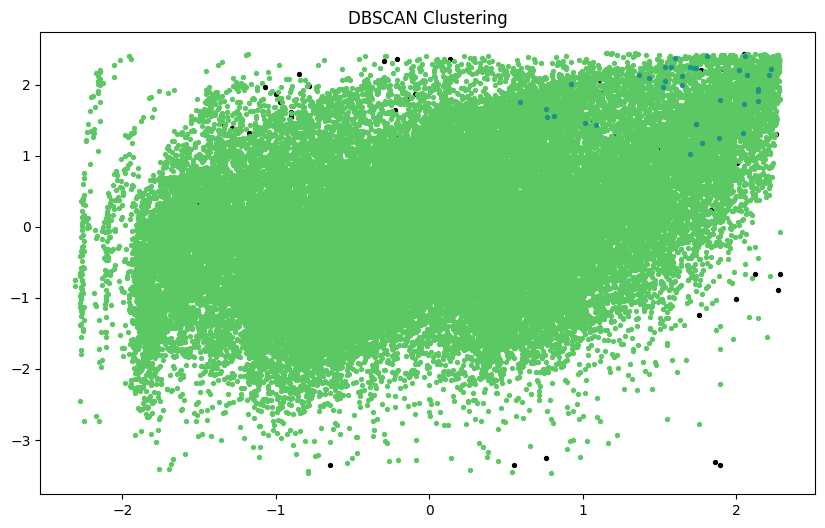

In [12]:
plt.figure(figsize=(10, 6))

df_done['label'] = labels

unique_labels = np.unique(df_done['label'])

palette = sns.color_palette("viridis_r", len(unique_labels))

for label in unique_labels:
    if label == -1:
        color = 'k' # plotting outliers as black
    else:
        color = palette[label % len(palette)]

    subset = df_done[df_done['label'] == label]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1], s=8, c=[color], label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title('DBSCAN Clustering')
plt.show()

----------

# SPECTRAL CLUSTERING

Similar to DBSCAN, I performed extensive search to find the best parameters for this spectral clustering. I investigated diiferent cluster sizes, affinities and assign_labels. Also to efficiently perform the clustering algorithm I did PCA to reduce the dimensionality of our dataset as it was nearly impossible to get any results by the means of this algorithm. I experimented with the amount of components for the PCA too.

In [9]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_done) 
  
X_normalized = normalize(X_scaled) 
X_normalized = pd.DataFrame(X_normalized) 
  
pca = PCA(n_components = 3) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2', 'P3'] 

I evaluated the performance of the algorithm using silhouette score again, which provided the best results for PCA with 3 components. The best performing combination is: 5 clusters with its affinity matrix built using nearest neighbors method and with the cluster_qr method for assigning labels. The below score is lower than desirable, but it was the best that could be found with the computational power I have.

In [10]:
spectral= SpectralClustering(n_clusters = 5, affinity ='nearest_neighbors', assign_labels= 'cluster_qr') 

labels_spectral = spectral.fit_predict(X_principal)

non_noise_mask = labels_spectral != -1
if np.sum(non_noise_mask) > 1:  
    score = silhouette_score(df_done[non_noise_mask], labels_spectral[non_noise_mask])
else:
    score = -1

print(f"Silhouette Score: {score}")

Silhouette Score: 0.15588463320211374


Visualization of the clustering:

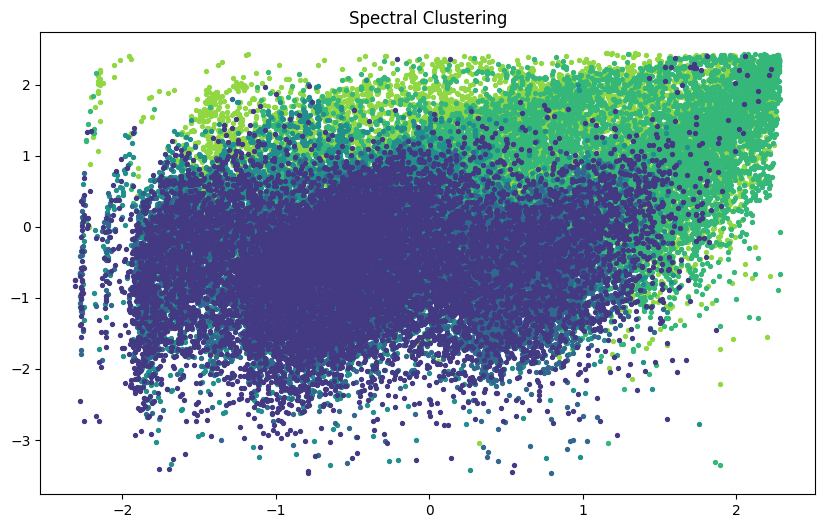

In [12]:
plt.figure(figsize=(10, 6))

df_done['label'] = labels_spectral

unique_labels = np.unique(df_done['label'])

palette = sns.color_palette("viridis_r", len(unique_labels))

for label in unique_labels:
    if label == -1:
        color = 'k' # plotting outliers as black
    else:
        color = palette[label % len(palette)]

    subset = df_done[df_done['label'] == label]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1], s=8, c=[color], label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title('Spectral Clustering')
plt.show()